In [17]:
from xgnn_src.node.utils import load_data

In [80]:
import dgl
import torch
import numpy as np

In [96]:
yelp1 = load_data('yelp', 'net_rur')
yelp1 = yelp1[0]
y1_pos = (yelp1.ndata['label'] == 1).nonzero()
y1_neg = (yelp1.ndata['label'] == 0).nonzero()

Done loading data from cached files.
net_rur Graph(num_nodes=45954, num_edges=98630,
      ndata_schemes={'test_mask': Scheme(shape=(), dtype=torch.uint8), 'val_mask': Scheme(shape=(), dtype=torch.uint8), 'train_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(), dtype=torch.int64), 'feature': Scheme(shape=(32,), dtype=torch.float32), 'feat': Scheme(shape=(32,), dtype=torch.float32)}
      edata_schemes={})


In [120]:
def getDegreeStats(g, pos, neg):
    posdegs = []
    for n in pos:
        posdegs.append(g.in_degree(n).item())
    print(np.sum(np.array(posdegs) != 0), len(posdegs))
    nedegs = []
    for n in neg:
        nedegs.append(g.in_degree(n).item())
    print(np.sum(np.array(nedegs) != 0), len(nedegs))

In [121]:
getDegreeStats(yelp1, y1_pos, y1_neg)

1217 6677
22614 39277


In [86]:
yelp = load_data('yelp', 'net_rsr')

Done loading data from cached files.
net_rsr Graph(num_nodes=45954, num_edges=6805486,
      ndata_schemes={'test_mask': Scheme(shape=(), dtype=torch.uint8), 'val_mask': Scheme(shape=(), dtype=torch.uint8), 'train_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(), dtype=torch.int64), 'feature': Scheme(shape=(32,), dtype=torch.float32), 'feat': Scheme(shape=(32,), dtype=torch.float32)}
      edata_schemes={})


In [87]:
yelp = yelp[0]

In [88]:
positive = (yelp.ndata['label'] == 1).nonzero()
negative = (yelp.ndata['label'] == 0).nonzero()

In [122]:
getDegreeStats(yelp, positive, negative)

6670 6677
39244 39277


In [96]:
def get_khop(g, idx, k):
    center = torch.tensor([idx])
    src, dst = [], []
    for i in range(k):
        s, c = g.in_edges(center)
        st, dt = torch.hstack([s, c]), torch.hstack(g.out_edges(center))
        src.append(st)
        dst.append(dt)
        center = s
    src, dst = torch.hstack(src), torch.hstack(dst)       
    uniq = torch.unique(torch.hstack([src, dst]))
    feats = g.ndata['feat'][uniq]
    mapping = {v.item(): i for i, v in enumerate(uniq)}
    ns, nd = [], []
    for s, d in zip(src, dst):
        ns.append(mapping[s.item()])
        nd.append(mapping[d.item()])
    return torch.tensor(ns), torch.tensor(nd), feats, uniq

In [20]:
amazon = load_data('amazon', 'net_upu')
amazon = amazon[0]

Done loading data from cached files.
net_upu Graph(num_nodes=11944, num_edges=351216,
      ndata_schemes={'test_mask': Scheme(shape=(), dtype=torch.uint8), 'val_mask': Scheme(shape=(), dtype=torch.uint8), 'train_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(), dtype=torch.int64), 'feature': Scheme(shape=(25,), dtype=torch.float32), 'feat': Scheme(shape=(25,), dtype=torch.float32)}
      edata_schemes={})


In [25]:
apositive = (amazon.ndata['label'] == 1).nonzero().flatten()
anegative = (amazon.ndata['label'] == 0).nonzero().flatten()

In [24]:
adegrees = amazon.in_degrees()

In [28]:
apos_degs = adegrees[apositive]
aneg_degs = adegrees[anegative]

In [35]:
apos_filter = apositive[(apos_degs != 0).nonzero().flatten()]
aneg_filter = anegative[(aneg_degs != 0).nonzero().flatten()]

In [40]:
a = list(amazon.in_edges(apos_filter[0]))

In [102]:
def generate_ego_graph(graph, nid, k):
    ns, nd, feat, old_idx = get_khop(graph, nid, k)
    ng = dgl.graph((ns, nd))
    ng.ndata['feat'] = feat
    ng.ndata['orig_id'] = old_idx
    return ng

In [103]:
pos_graphs = [generate_ego_graph(amazon, p, 2) for p in apos_filter]    

In [110]:
pos_numnodes = np.array([g.num_edges() for g in pos_graphs])

In [116]:
import pandas as pd
import seaborn as sns

In [118]:
df = pd.DataFrame({"num_edges": pos_numnodes})

In [159]:
df_filter = df[df['num_edges'] <= 4000].index.to_numpy()

In [146]:
df[df['num_edges'] <= 4000]

,num_edges
0,3672
1,58
2,32
3,3018
81,122
...,...
688,1428
689,48
690,4
691,12


<AxesSubplot:xlabel='num_edges', ylabel='Count'>

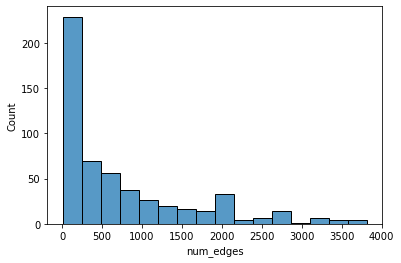

In [145]:
sns.histplot(df[df['num_edges'] < 4000], x='num_edges')

In [129]:
neg_graphs = [generate_ego_graph(amazon, p, 2) for p in aneg_filter]    

In [131]:
neg_numedges = [ng.num_edges() for ng in neg_graphs]

In [132]:
ndf = pd.DataFrame({'num_edges': neg_numedges})

In [150]:
ndf_filter = ndf[ndf['num_edges'] <= 4000].index

In [148]:
ndf[ndf['num_edges'] <= 4000]

,num_edges
0,4
1,392
2,680
3,384
4,66
...,...
9526,4
9527,12
9528,68
9529,70


<AxesSubplot:xlabel='num_edges', ylabel='Count'>

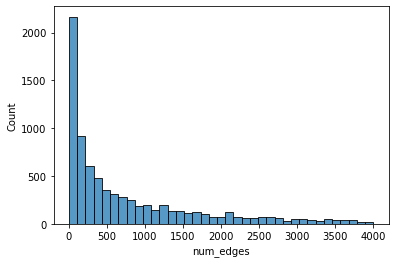

In [147]:
sns.histplot(ndf[ndf['num_edges'] <= 4000], x='num_edges')

In [151]:
def filter_graphs(graphs, indices):
    ngraphs = [graphs[i] for i in indices]
    return ngraphs

In [160]:
pos_graph_filters = filter_graphs(pos_graphs, df_filter)

In [157]:
neg_graph_filters = filter_graphs(neg_graphs, ndf_filter)

In [162]:
import pickle as pkl

In [186]:
with open('./datasets/amazon_ego.pkl', 'wb') as f:
    pkl.dump((pos_graph_filters, neg_graph_filters, torch.hstack([apos_filter, aneg_filter]).tolist()), f)

In [167]:
neg_graph_filters2 = np.random.choice(neg_graph_filters, len(pos_graph_filters), replace=False)

In [185]:
with open('./datasets/amazon_ego_2.pkl', 'wb') as f:
    graphs = pos_graph_filters + neg_graph_filters2.tolist()
    l = len(pos_graph_filters)
    labels = np.ones(l).tolist() + np.zeros(l).tolist()
    egos = torch.hstack([apos_filter[df_filter], aneg_filter[ndf_filter]]).tolist()
    pkl.dump((graphs, labels, egos), f)

In [187]:
from dgl.data import BA2MotifDataset

In [188]:
ba = BA2MotifDataset()

Done loading data from cached files.


In [192]:
ba[0]

(Graph(num_nodes=25, num_edges=50,
       ndata_schemes={'feat': Scheme(shape=(10,), dtype=torch.float32)}
       edata_schemes={}),
 tensor([1, 0]))